In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
print(torch.__version__)
print(torchvision.__version__)

1.4.0
0.5.0


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from skimage import color
print("Torch version: "+str(torch.__version__))
print("Current device: "+str(torch.cuda.current_device()))
print("Is cuda available? "+str(torch.cuda.is_available()))

if torch.cuda.is_available():
    device =torch.device('cuda')
    print("Running on the GPU")
else:
    device=torch.device("cpu")
    print("Running on the CPU")
    

Torch version: 1.4.0
Current device: 0
Is cuda available? True
Running on the GPU


In [9]:
from torch.utils.tensorboard import SummaryWriter
tb=SummaryWriter().to(device)

ImportError: TensorBoard logging requires TensorBoard with Python summary writer installed. This should be available in 1.14 or above.

#### Import data from .pt

In [5]:
train_data_1=torch.load("set_3/pt/new/set_3_train.pt")
# train_data_2=torch.load("set_3/pt/set_3_train_2.pt")
# train_data_3=torch.load("set_3/pt/set_3_train_3.pt")
# train_data_3=torch.load("set_3/pt/set_3_train_3.pt")
# train_data_4=torch.load("set_3/pt/set_3_train_4.pt")
# test_data=torch.load("set_3/pt/set_3_test.pt")
# test_data=torch.load("set_2/.pt/set_2_test.pt")
# del train_d_loader
# train_data=train_data_1+train_data_2+train_data_3
# train_data=train_data_4+train_data_5
# test_data=torch.load("set_1_test.pt")

In [6]:
train_data=train_data_1
len(train_data)

52529

[]

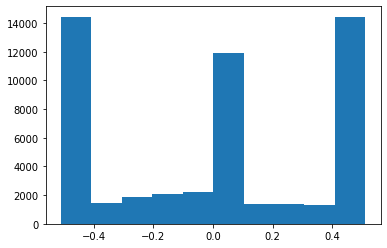

In [8]:
lis=[]
for val in range(len(train_data)):
    lis.append(train_data[val][1])
plt.hist(lis,bins=10)
plt.plot()


In [4]:
len(train_data)

18908

In [ ]:
# test=torch.load("set_3/pt/set_3_train_5.pt")

In [19]:
del train_data_1, train_data_2
# train_data_4,train_data_5=0,0

In [7]:
train_d_loader=torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
# test_d_loader=torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

#### Single batch visualization and image shape

torch.Size([100, 1, 224, 224])
torch.Size([3, 2262, 2262])
torch.Size([2262, 2262, 3])


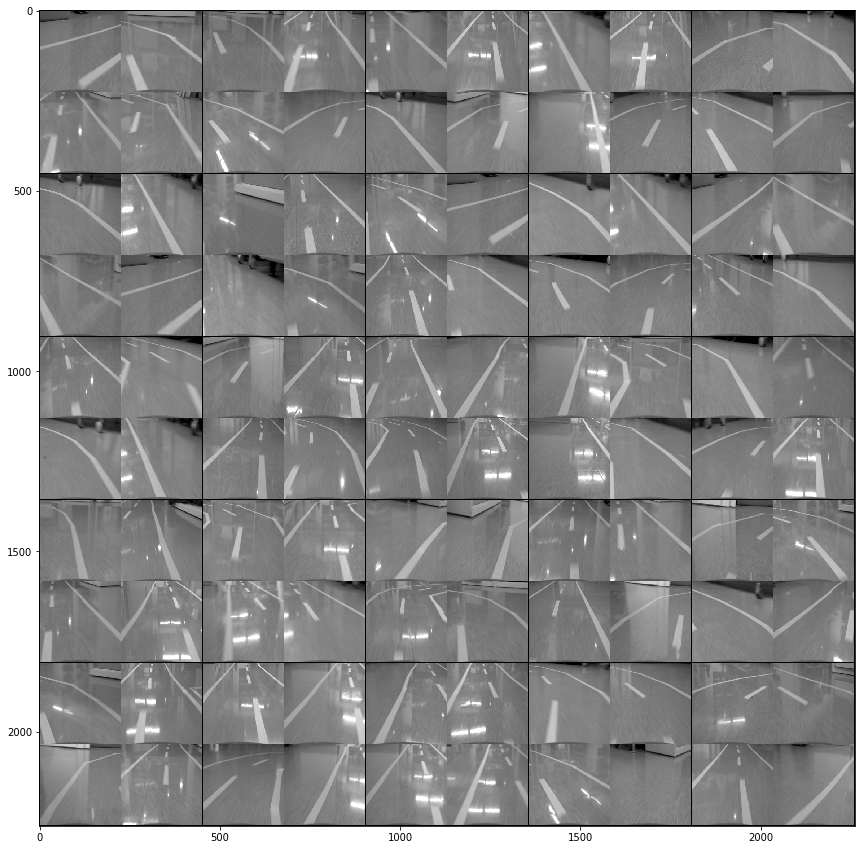

In [8]:
batch=next(iter(train_d_loader))
images,labels=batch
images=images.reshape(100,1,images.shape[3],images.shape[3])
img_shape=images[0][0].shape
sample=images[0][0]
print((images.shape))
grid=torchvision.utils.make_grid(images,nrow=10)
# tb.add_image("images",grid)
# tb.add_graph(Nnet,images)
if images.shape[0]<=100:
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print(grid.shape)
    print(np.transpose(grid,(1,2,0)).shape)

#### Model

In [9]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.LayerNorm(normalized_shape=(224,224))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3,stride=2)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(in_channels=36, out_channels=48, kernel_size=3,stride=1)
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.drop=nn.Dropout(0.7)

        self.fc1 = nn.Linear(in_features=64*8*8, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=10)
        self.out = nn.Linear(in_features=10, out_features=1)

    def forward(self, t):
        t=self.norm(t.float())
        self.nor=t
        
        t = F.elu(self.conv1(t.float()))
        t = F.max_pool2d(t, kernel_size=2)
        self.c1=t
        
        t = F.elu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2)
        self.c2=t
        
        
        t = F.elu(self.conv3(t))
        t = F.max_pool2d(t, kernel_size=2)
        self.c3=t


        t = F.elu(self.conv4(t))
        self.c4=t
        t = F.elu(self.conv5(t))
        self.c5=t
#         self.t=t
#         print(t.shape)
        
        t=self.drop(t)
        t=t.reshape(-1,t.shape[1]*t.shape[2]*t.shape[3])
        t=F.elu(self.fc1(t))
        t=F.elu(self.fc2(t))
        t=F.elu(self.fc3(t))
        t=F.elu(self.fc4(t))
        t=self.out(t)
        return t

network = Network().to(device)

#### Single image prediction

In [6]:
print(sample.shape)

torch.Size([224, 224])


In [154]:
sample=sample.reshape((1,224,224)).unsqueeze(0).to(device)
print(sample.shape)
pred= network(sample)
print(pred)

torch.Size([1, 1, 224, 224])
tensor([[0.2250]], device='cuda:0', grad_fn=<AddmmBackward>)


#### Image visualization after convolution

In [151]:
# plot_1=network.c1.cpu()
# plot_1.shape
# plot_1.reshape(21,1,plot_1.shape[2],plot_1.shape[2])
# network.c2=network.c2.to("cpu")
# network.c3=network.c3.to("cpu")
# network.c4=network.c4.to("cpu")
# network.c5=network.c5.to("cpu")

# network.c1=network.c1.unsqueeze(2)
# network.c1=network.c1.squeeze(0)
# network.c1.shape

# network.c1.shape
# print(network.c1.shape)
# grid_1=torchvision.utils.make_grid(plot_1.permute(1,3,2,0),nrow=10)
# grid_1.shape
# print(grid_1.shape)
# grid_1.numpy()
# plt.imshow(grid_1.permute(1, 2, 0))
# grid_2=torchvision.utils.make_grid(network.c2,nrow=10)
# grid_3=torchvision.utils.make_grid(network.c3,nrow=10)
# grid_4=torchvision.utils.make_grid(network.c4,nrow=10)
# grid_5=torchvision.utils.make_grid(network.c5,nrow=10)
# plt.figure(1)
# plt.figure(figsize=(5,5))
# grid_1=grid_1.detach().numpy()
# print(grid_1.shape)
# plt.imshow(grid_1.detach().numpy())

#### Training by epocs

In [ ]:
# t_loader=torch.utils.data.DataLoader(train,batch_size=100)
ls=nn.MSELoss()
optimizer=optim.Adam(network.parameters(),lr=0.01)

for epoch in range(3):
    t_loss=0
    t_correct=0
    for batch in train_d_loader:
        
        images,labels=batch
        images=images.reshape(images.shape[0],1,224,224).to(device)
        labels=labels.to(device)

        preds=network(images)
        preds=preds.reshape(preds.shape[0])
        loss =ls(preds, labels)
#         print(preds.shape)

        optimizer.zero_grad() ## avoid accumilation of gradients of previous loop
        loss.backward() ############# calcu late the gradients ########
        optimizer.step() ############ update the weight #########
        t_loss+=loss.item()

    print("Epoch "+str(epoch)+">> "+"Total loss: "+str(t_loss), "Loss: "+ str(t_loss/len(train_data)))

Epoch 0>> Total loss: 6120575.88025824 Loss: 116.5180353758541


#### Test data prediction

In [28]:
def all_prediction(model,loader):
    all_pred=torch.tensor([]).to(device)
    all_labels=torch.tensor([]).to(device)
    for batch in loader:
        images,labels=batch
        images=images.reshape(images.shape[0],1,224,224).to(device)
        labels=labels.to(device)
        preds=model(images)
        preds=preds.reshape(preds.shape[0])
        
        all_labels=torch.cat((all_labels,labels),dim=0)
        all_pred=torch.cat((all_pred,preds),dim=0)
    return all_pred,all_labels

In [29]:
with torch.no_grad():
    train_preds,labels=all_prediction(network,test_d_loader)

In [30]:
error=[]
for val in range(train_preds.shape[0]):
    error.append((train_preds[val]-labels[val])**2)
mse=np.sum(error)/len(error)
print("MSE of test data: "+ str(mse))

MSE of test data: tensor(0.0067, device='cuda:0')


####  Single prediction visualization 

tensor([[-0.4711]], grad_fn=<AddmmBackward>)
tensor(-0.5000)


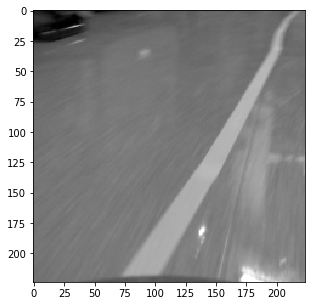

In [42]:
network_cpu=network.to("cpu")
batch=next(iter(test_d_loader))
img,lab=batch
img=img.reshape(100,1,224,224)
img=img[0].unsqueeze(0)
print(network_cpu(img))
plt.figure(figsize=(5,5))
plt.imshow(img.squeeze(),cmap='gray')
print(lab[0])

#### Saving network

In [25]:
torch.save(network.state_dict(),"set_2_5epoch_0.001.pth")

#### Test saved model

In [92]:
network = Network().to(device)
network.load_state_dict(torch.load("set_1_7epoch.pth"))

<All keys matched successfully>